In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

---

## Century21

In [33]:
file_path = 'data/century21Paris.csv'
data = pd.read_csv(file_path)

#### Visualisation

In [34]:
df = data.copy()
df['Prix (€)'] = df['Prix (€)'].astype(float)
df.shape
df.dtypes.value_counts() # Différentes types de données des colonnes

int64      2
float64    2
object     1
Name: count, dtype: int64

In [35]:
df.head()

,Ville,Arrondissement,Surface (m2),Pièce(s),Prix (€)
0,PARIS,75008,9.00,1,536.0
1,PARIS,75019,49.70,2,1446.0
2,PARIS,75016,42.87,1,1480.0
3,PARIS,75013,84.30,4,2550.0
4,PARIS,75015,45.28,2,1650.0


In [36]:
df.columns

Index(['Ville', 'Arrondissement', 'Surface (m2)', 'Pièce(s)', 'Prix (€)'], dtype='object')

#### Statistiques et Filtres

In [37]:
# Counting

df['Ville'].value_counts()

Ville
PARIS    71
Name: count, dtype: int64

In [52]:
# Sorting

df.sort_values('Surface (m2)')

,Ville,Arrondissement,Surface (m2),Pièce(s),Prix (€)
0,PARIS,75008,9.00,1,536.0
21,PARIS,75018,10.10,1,385.0
30,PARIS,75010,10.53,1,650.0
60,PARIS,75016,14.67,1,700.0
10,PARIS,75016,19.31,1,950.0
...,...,...,...,...,...
6,PARIS,75015,100.69,4,2450.0
66,PARIS,75016,113.54,4,4500.0
17,PARIS,75016,193.46,6,6373.0
70,PARIS,75006,252.40,12,15720.0


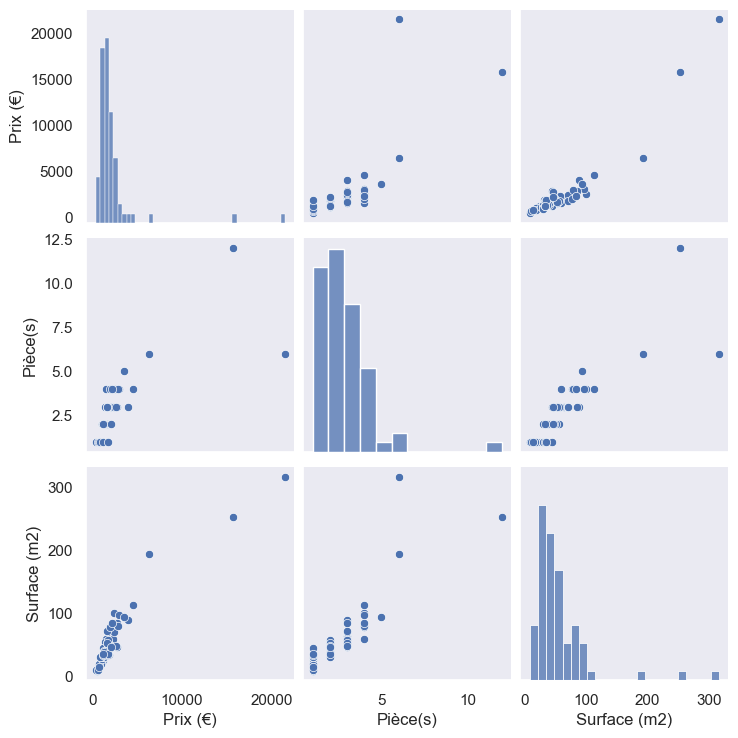

In [53]:
sns.pairplot(df[['Prix (€)', 'Pièce(s)', 'Surface (m2)']])

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_1193/1326104219.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster'] = cluster_labels


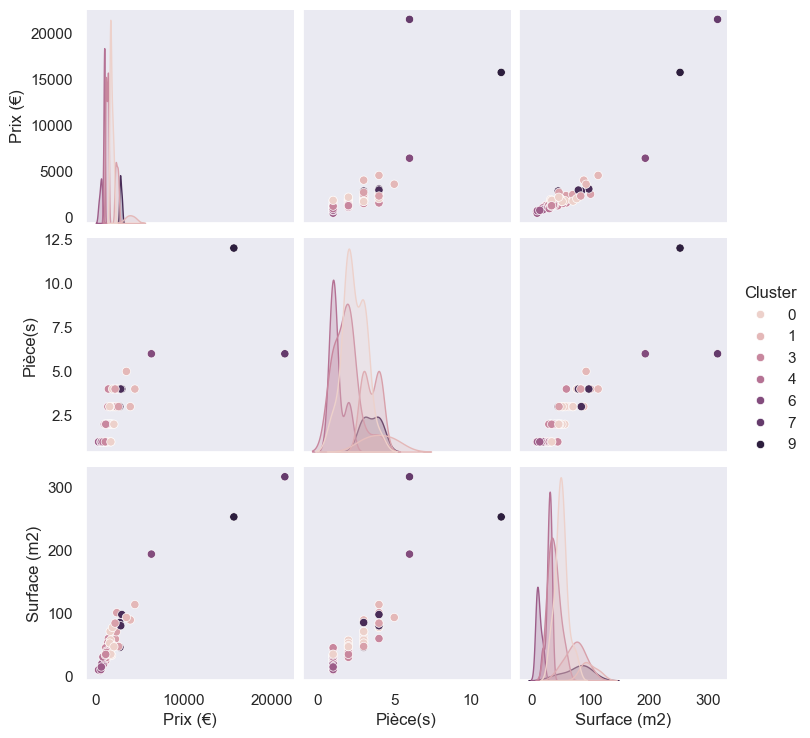

In [54]:
from sklearn.cluster import AgglomerativeClustering

new_df = df[["Prix (€)","Pièce(s)","Surface (m2)"]]
clustering = AgglomerativeClustering(n_clusters=10, linkage='ward')
cluster_labels = clustering.fit_predict(new_df)
new_df['Cluster'] = cluster_labels

sns.pairplot(new_df, hue='Cluster')

### Analyse de Fond :
- **Visualisation de la target** :
- **Signification des variables** :
- **Relation Variables / Target** :

In [38]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])

numerical_df.describe(include='all')

,Arrondissement,Surface (m2),Pièce(s),Prix (€)
count,71.000000,71.000000,71.000000,71.000000
mean,75022.295775,57.289718,2.492958,2275.295775
std,29.003150,48.430062,1.672238,2993.795677
min,75003.000000,9.000000,1.000000,385.000000
25%,75011.000000,33.110000,1.000000,1195.000000
50%,75015.000000,46.810000,2.000000,1685.000000
75%,75018.000000,61.850000,3.000000,2218.500000
max,75116.000000,316.010000,12.000000,21500.000000


### Analyse dataset

In [39]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(numerical_df)
data_scaled = scaler.transform(numerical_df)
dataStd = pd.DataFrame(data_scaled, columns=numerical_df.columns)

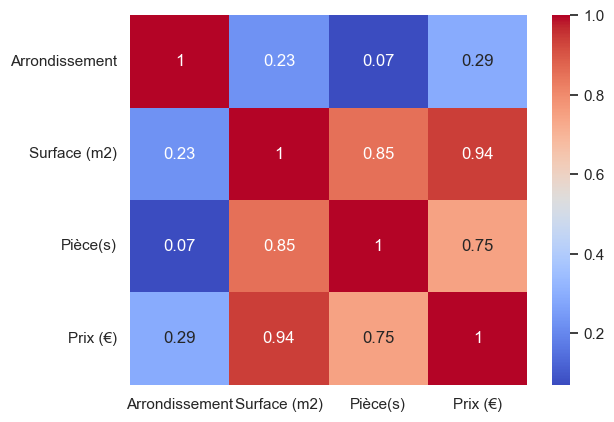

In [40]:
sns.heatmap(dataStd.corr(), annot=True, cmap='coolwarm');

On note une forte corrélation positive entre la surface et le prix, indiquant que les propriétés avec de plus grandes surfaces ont tendance à être plus chères. De même, il y a une corrélation assez élevée entre le nombre de pièces et la surface, ainsi qu'entre le nombre de pièces et le prix, ce qui reflète des relations logiques où des maisons plus grandes avec plus de pièces coûtent généralement plus cher. L'arrondissement semble avoir une corrélation plus faible avec ces variables, bien que toujours positive. Ces relations suggèrent une influence significative de la taille et du nombre de pièces sur le prix du marché immobilier, tandis que la localisation par arrondissement a une influence moindre sur ces facteurs.

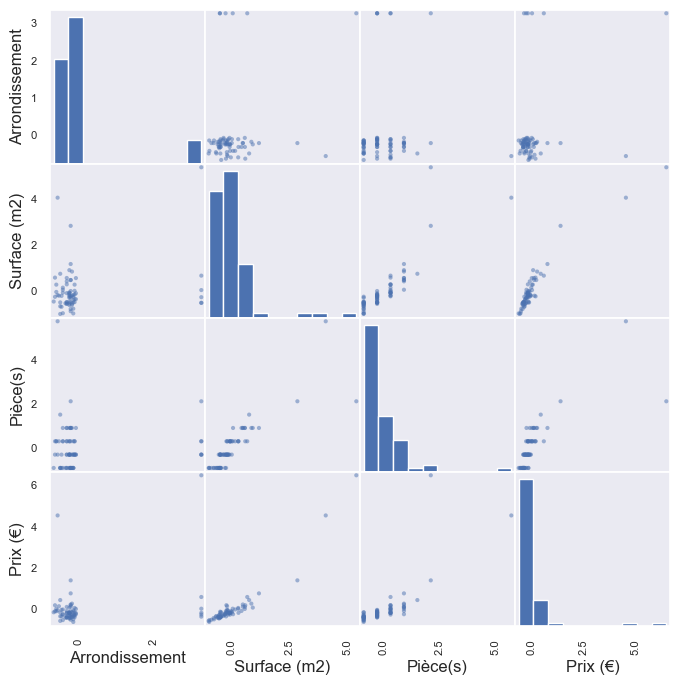

In [41]:
pd.plotting.scatter_matrix(dataStd, figsize=(8, 8));

On observe une concentration de données pour des surfaces plus petites et des prix inférieurs, ce qui suggère que la majorité des propriétés dans cet ensemble de données sont de taille modeste et relativement abordables. Les diagrammes de dispersion hors de la diagonale indiquent une densité plus élevée de points vers le bas des graphiques pour le prix par rapport à l'arrondissement, la surface et le nombre de pièces, ce qui pourrait indiquer que le prix augmente avec ces variables, bien que la dispersion soit large et que les tendances ne soient pas linéaires. Les valeurs aberrantes sont visibles, particulièrement dans les données de prix, où quelques propriétés ont des prix bien plus élevés que la moyenne. Ce graphique offre un aperçu de la manière dont ces variables immobilières interagissent et peuvent influencer le prix des propriétés.

### Outlier detection

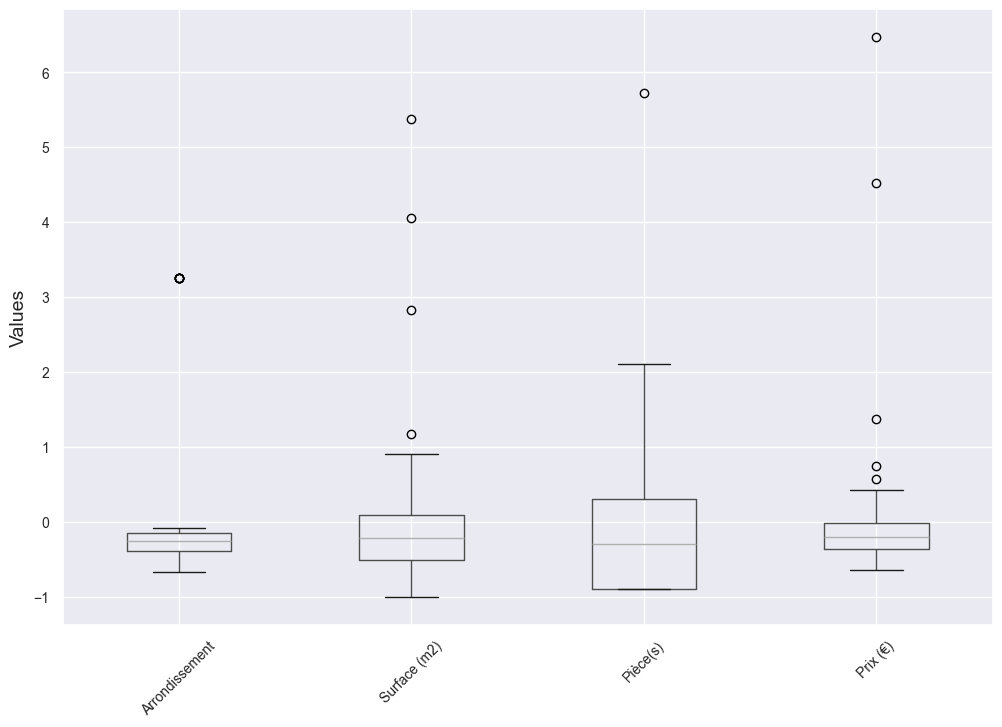

In [42]:
plt.figure(figsize=(12, 8))

dataStd.boxplot(rot=45, fontsize=10)
plt.ylabel("Values", fontsize=14)
plt.show()

 Les boîtes pour l'arrondissement et le nombre de pièces sont relativement symétriques, avec des médianes centrées et peu de valeurs aberrantes, ce qui suggère une distribution équilibrée. En revanche, la surface et le prix ont des médianes plus proches du premier quartile et présentent un certain nombre de valeurs aberrantes, indiquant une distribution asymétrique avec une longue queue de valeurs plus élevées. Cela peut indiquer que, bien que la majorité des propriétés aient des surfaces et des prix plus modérés, il existe un nombre significatif de propriétés avec des surfaces très grandes et des prix élevés.

In [43]:
outliers_count = 0

for col in dataStd.columns:
    col_values = dataStd[col]
    z_scores = (col_values - col_values.mean()) / col_values.std()
    outliers_count += (abs(z_scores) > 3).sum()

# Display the count of lines to be removed
print(f"Total lines to be removed: {outliers_count}")

Total lines to be removed: 11


In [44]:
# Initialize the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)

isolation_forest.fit(dataStd)
outlier_predictions = isolation_forest.predict(dataStd)

outliers_count = (outlier_predictions == -1).sum()

print(f"Total outliers identified: {outliers_count}")

Total outliers identified: 4


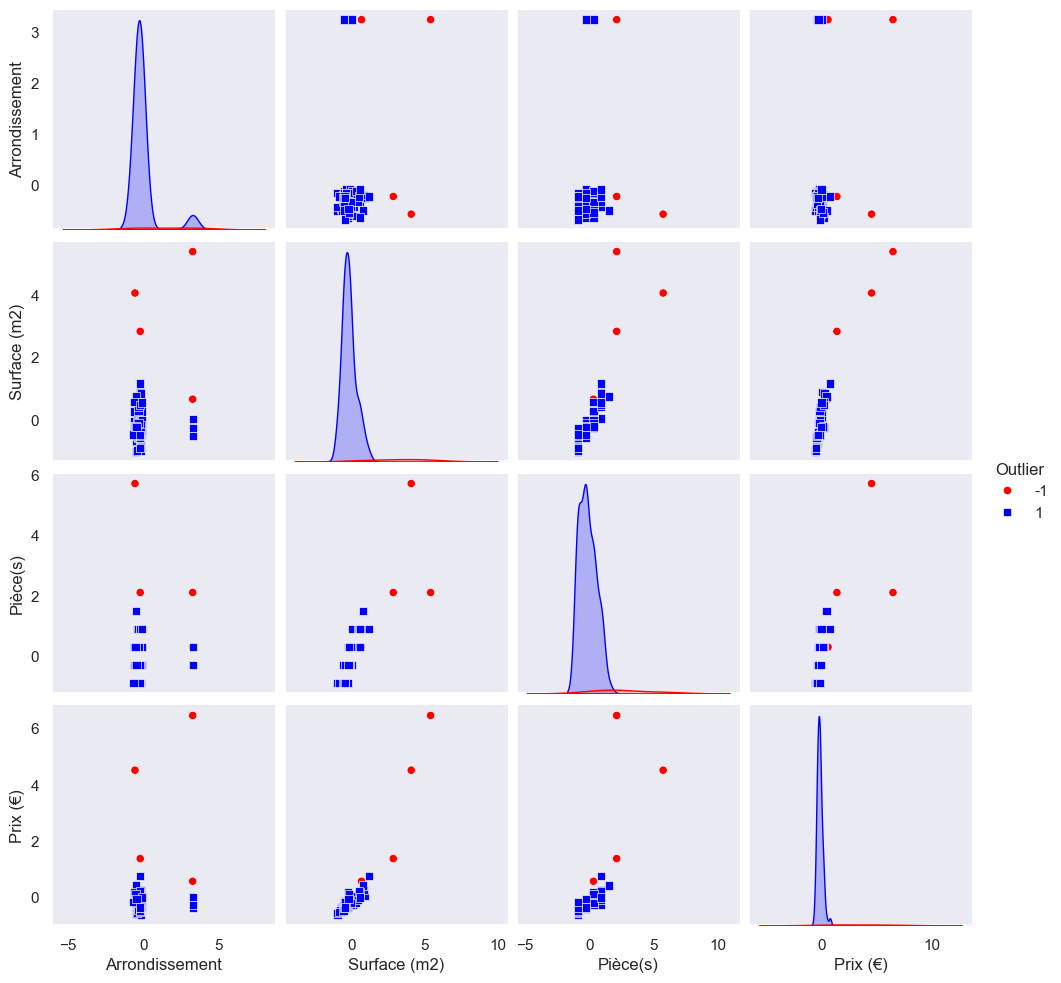

In [45]:
# Add a new column 'Outlier' to the DataFrame indicating whether each row is an outlier or not
dataStdCopy = dataStd.copy()
dataStdCopy['Outlier'] = outlier_predictions

# Create pair plots using seaborn
sns.set(style="dark")
sns.pairplot(dataStdCopy, hue='Outlier', palette={-1: 'red', 1: 'blue'}, markers=['o', 's'], height=2.5)
plt.show()

### Réduction de dimension

In [46]:
pca = PCA()
pca.fit(dataStd)
pca_data = pca.transform(dataStd)
n = dataStd.shape[0] # nb of individuals
p = dataStd.shape[1] # nb of variables
print(n, "samples")
print(p, "variables")

71 samples
4 variables


In [47]:
explained_variances = pca.explained_variance_
simple_var_proportions = explained_variances / explained_variances.sum()
cumulative_var_proportions = np.cumsum(simple_var_proportions)
labels = [f'PC{i}' for i in range(1, len(explained_variances) + 1)]

summary_table = pd.DataFrame({
    'Explained Variance': explained_variances,
    'Simple Variance Proportion': simple_var_proportions,
    'Cumulative Variance Proportion': cumulative_var_proportions
}, index=labels)

summary_table

,Explained Variance,Simple Variance Proportion,Cumulative Variance Proportion
PC1,2.799329,0.689976,0.689976
PC2,0.979681,0.241471,0.931446
PC3,0.235890,0.058142,0.989588
PC4,0.042243,0.010412,1.000000


<BarContainer object of 4 artists>

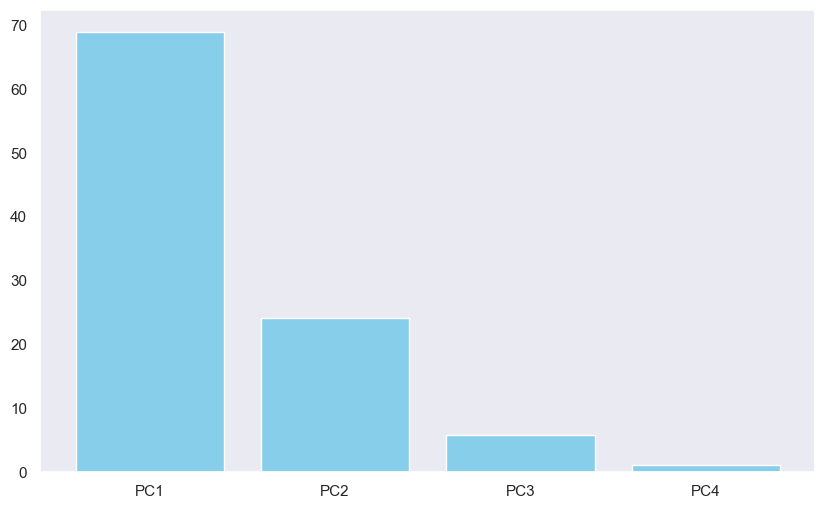

In [48]:
# Convert simple variance proportions to percentages
simple_var_proportions_percent = simple_var_proportions * 100

plt.figure(figsize=(10, 6))
plt.bar(summary_table.index, simple_var_proportions_percent, color='skyblue')

In [49]:
singular_values = np.sqrt(pca.explained_variance_)
corvar_data = {'id': dataStd.columns}
for k in range(p):
    corvar_data[labels[k]] = pca.components_[k,:] * singular_values[k]

coordvar = pd.DataFrame(corvar_data)
coordvar

,id,PC1,PC2,PC3,PC4
0,Arrondissement,0.319862,0.949670,-0.100490,0.001643
1,Surface (m2),0.986556,-0.082255,0.092097,0.160451
2,Pièce(s),0.896906,-0.266015,-0.369414,-0.051128
3,Prix (€),0.958793,0.016664,0.284330,-0.117818


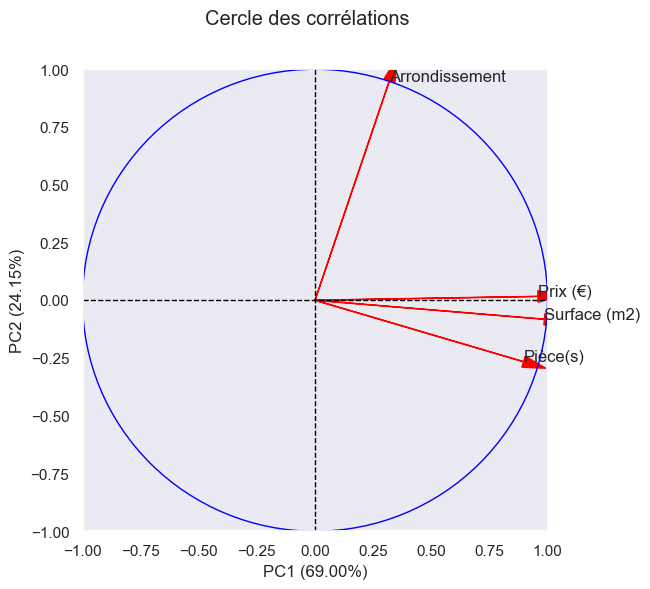

In [50]:
fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des titres
pc1_label = 'PC1 ({:.2f}%)'.format(simple_var_proportions_percent[0])
pc2_label = 'PC2 ({:.2f}%)'.format(simple_var_proportions_percent[1])
axes.set_xlabel(pc1_label)
axes.set_ylabel(pc2_label)

# Ajout des axes
axes.axvline(x=0, color='black', linestyle='--', linewidth=1)
axes.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Ajout des noms des variables et des flèches
for j in range(p):
    axes.arrow(0, 0, coordvar[labels[0]][j], coordvar[labels[1]][j], head_width=0.05, head_length=0.1, fc='red', ec='red')
    axes.text(coordvar[labels[0]][j], coordvar[labels[1]][j], coordvar["id"][j])

# Ajout du cercle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_artist(circle)

plt.show()

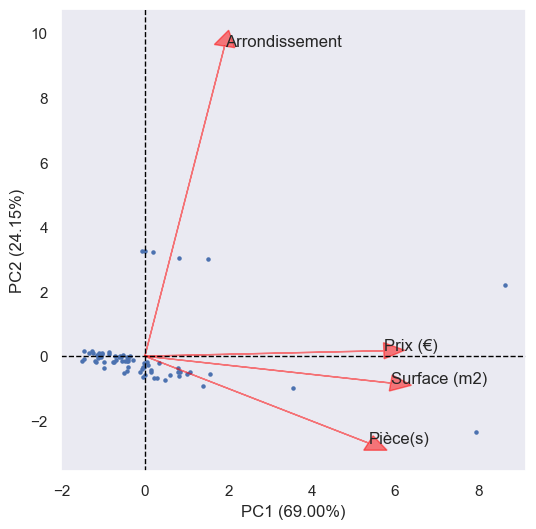

In [51]:
fig, axes = plt.subplots(figsize=(6, 6))

# Ajout des titres
pc1_label = 'PC1 ({:.2f}%)'.format(simple_var_proportions_percent[0])
pc2_label = 'PC2 ({:.2f}%)'.format(simple_var_proportions_percent[1])
axes.set_xlabel(pc1_label)
axes.set_ylabel(pc2_label)

# Ajout des axes
axes.axvline(x=0, color='black', linestyle='--', linewidth=1)
axes.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.scatter(pca_data[:,0],pca_data[:,1],s=5)
for i in range(pca.components_.shape[1]):
    axes.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5, color='red', head_width=0.5, head_length=0.5)
    axes.text(pca.components_[0,i]*10,pca.components_[1,i]*10,dataStd.columns[i])

plt.show()